# Let's detect some surfaces!

In this project our task is to detect the floor surface the robots are moving on. Data is collected from Inertial Measurement Units (IMU). 
This is from the Kaggle competition at https://www.kaggle.com/c/career-con-2019
The objective is to help robots navigate by detecting the surface they are moving on. We have access to orientation, angular velocity and linear acceleration.

# What's new here
    - I use CNN as the classifier.
    - Since the number of channels is ~7 to 9, it was not possible to use pre-trained models. I tried a couple but they all had hard requirement of 3-4 channels.
    - I implement an image generator which rotates the data in time. It should not matter where our measurement started.
    - I use normalization to scale data.
    
# Results
    - With about 30 epochs we get accuracy close to 90% for validation and around 60-70% for test data.
    - This is a fairly good result so far. We can make the model more complicated by bringing in the frequncy analysis, but that's for another work.  
    - It is well established in my other notebook (based on random forest) and from other people's kernels that this data is leaky. Basically, orientation plays an important role in improving accuracy. This is weird because on any surface we should be able to go in many directions. 
    - Given the leaky nature of this data, I take this as an exercise for learning more rather than a task to get the highest accuracy. 
    
# What I learned
    - Detecting leaky data
    - How to implement my own image generator
    - How to implement call backs on Keras for both model.fit and model.fit_generator
    - Angular velocity and linear acceleration signal, vibration frequencies, fourier transform of these, etc.
    - Running CNN on this data does not seem to be ideal due to the long time needed for training which makes cross-validation difficult. 

In [1]:
# i think we should implement CV on surface and group_id.
import os
import time
import numpy as np
import pandas as pd
from seaborn import countplot,lineplot, barplot
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.utils import shuffle as sk_shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import precision_score, recall_score, f1_score
import keras as keras
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


## Data Exploration

In [2]:
# Input parameters
r_image_height = 8
r_image_width  = 16
col_keywords = ['e_', 'angular', 'linear']    # columns starting with these keywords are included in model. 

shuffle_train = True
HPF_enabled = False

# Ignore UndefinedMetricWarning for Precision/Recall
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [3]:
train = pd.read_csv('../input/X_train.csv')
test = pd.read_csv('../input/X_test.csv')
target = pd.read_csv('../input/y_train.csv')
submission = pd.read_csv('../input/sample_submission.csv')

In [4]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [5]:
train.shape, test.shape

((487680, 13), (488448, 13))

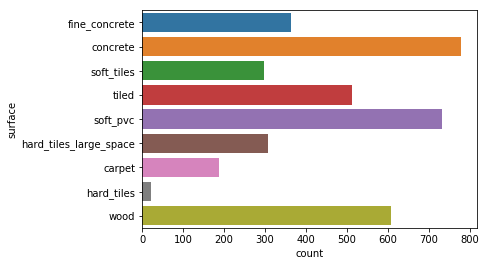

In [6]:
countplot(y='surface', data=target)
plt.show()

This is a multi-class classification problem. It's supervised and has imbalanced classes.
Each measurement has 128 data points taken over time for each sensor. The identifier for each measurement is series_id. Then each measurement is repeated on the same surface multiple times which is identified by group_id.

The chart below shows the number of group_id values for each surface in training data. 

In [7]:
target.groupby('surface')['group_id'].nunique()

surface
carpet                     4
concrete                  15
fine_concrete              7
hard_tiles                 1
hard_tiles_large_space     5
soft_pvc                  14
soft_tiles                 6
tiled                      9
wood                      12
Name: group_id, dtype: int64

Let's check out the features for a specific series_id.
So we plot each feature vs index. Each graph has 128 points which is the number of points per each series_id. This is one recording session.

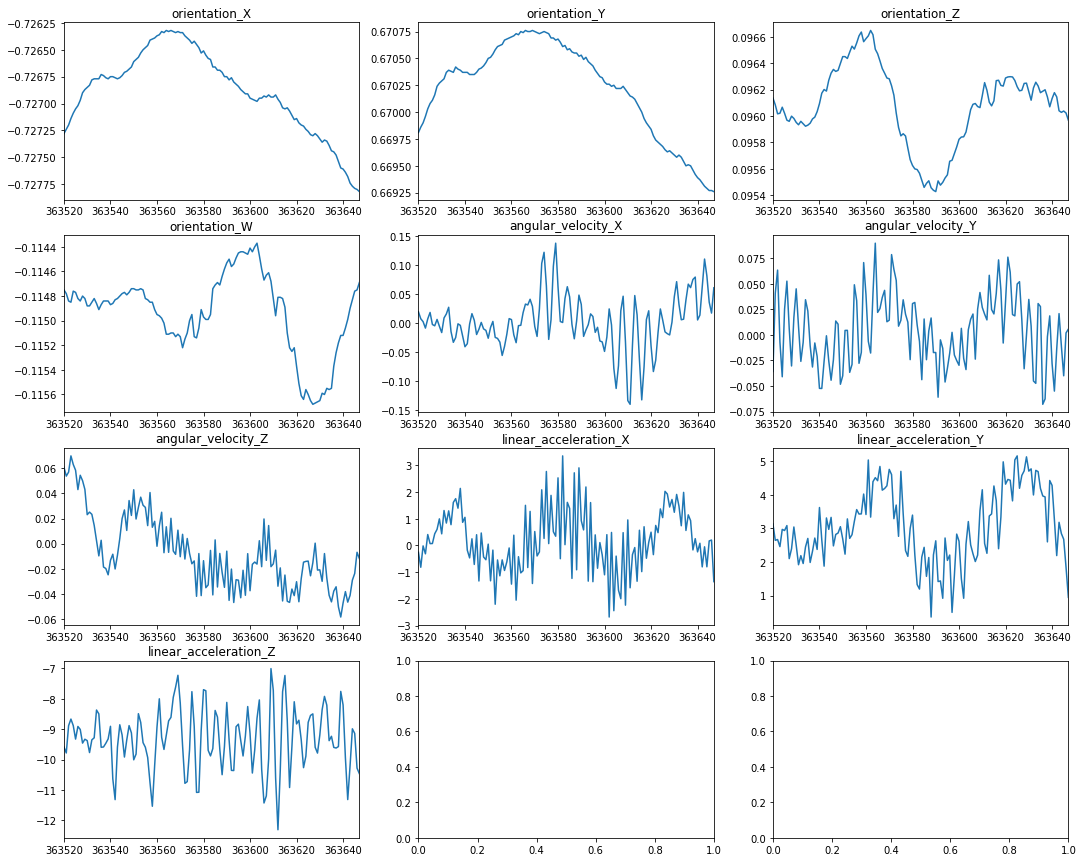

In [8]:
temp_sid = train.series_id.sample(1)
df = train[train.series_id.isin(temp_sid)]

fig, ax =plt.subplots(4,3, figsize=(18,15))
cols = df.columns[3:]
for i, col in enumerate(cols):
    plt.subplot(4,3, i+1)
    df[col].plot()
    plt.title(col)

Here's all the data plotted together. 
    - Each row is for 1 feature. 
    - Each column is for 1 surface. 
    - X-axis is just sample number. 
    - Y-axis is the feature values. 
    - Colors represent different series_id.
    - E_X, E_Y, E_Z are euler transformations of orientation data. See Feature Engineering for code.


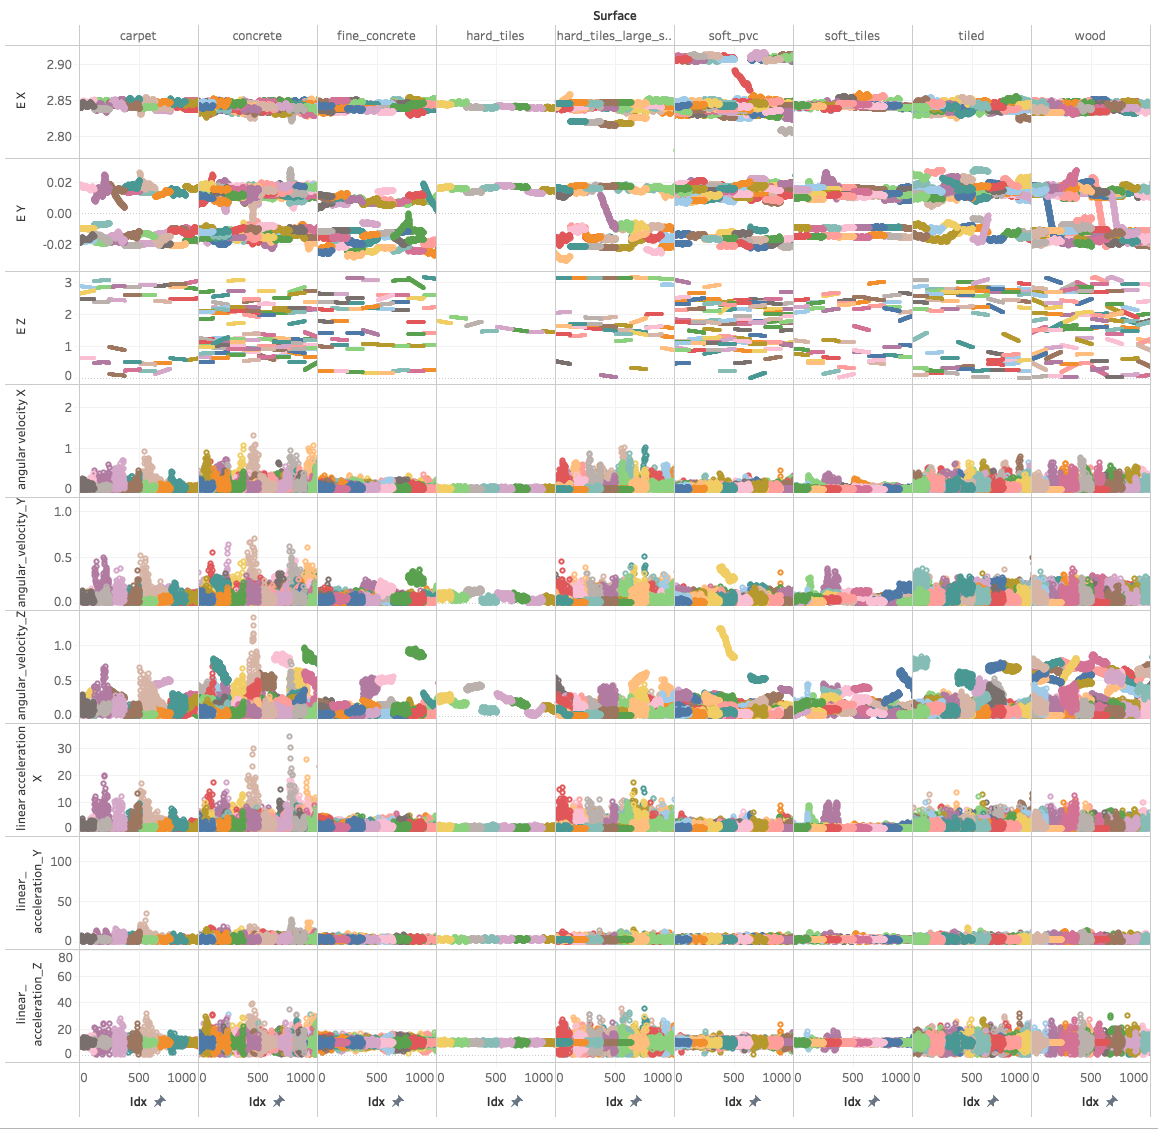

In [9]:
from IPython.display import Image
Image("../input/plain-data/Plain_Data.png")

#### What do we learn from above?

    E_X is pretty much constant. 
    E_Y takes values between -0.02 and +0.02 with most data aggregated in certain locations.
    E_Z seems to be the main direction in which the robot drove.

    Between the velocity and acceleration features, there seems to be distinct difference between the magnitude among different surfaces. So this might be useful. 
    We cannot see differences in vibration frequencies from here but we are hoping that CNNs can detect this.
    There are differences in magnitude of velocity and acceleration in different directions. I'll skip detailed explanation but I have looked at these differences.



## Why CNN?

In determining the surface, we probably need to look at the patterns in sensor data. For example specific range of frequencies or amplitudes which can distinguish between surfaces. One way would be to check the fourier transform. Another way would be to let a convolutional network learn the patterns and come up with a good classifier. 


## Data manipulation

In this regard, I treat the input data as images each with 128 pixels (or data points). We can reshape the 128 points to 8x16 or 128x1 image. I use 16x8 which produced good results. Then each of the features (orientation, angular velocity and linear acceleration) would be 1 channel. 

I prefer not to use orientation since the surface should not depend on that. But it is well established in my other notebook (Random Forest) that the data is most likely leaky and orientation plays an important role in determining the surface. So in real world, I would talk to the data collectors to understand what happened and try to collect better data. We don't have that luxary here, so I'm going to treat this as is and play with it.

So I will be using 3x euler features, 2x angular velocity and 2x linear acceleration features totaling 7 features. The input image will have 7 channels and be of size 8x16. 

Here's a sample data of input image.

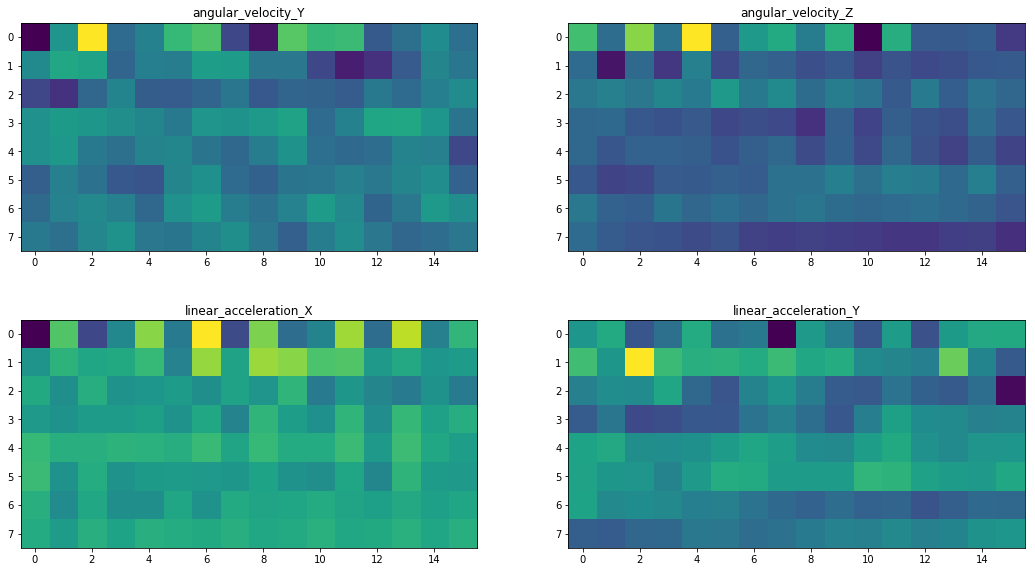

In [10]:
# Let's plot 4 of the features which will form an image with 4 channels. Each image below is for 1 channel.
fig, ax =plt.subplots(2,2, figsize=(18,10))
i = 1

temp_sid = train.series_id.sample(1)
df = train[train.series_id.isin(temp_sid)]

cols = ['angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X', 'linear_acceleration_Y']

for i, col in enumerate(cols):
    plt.subplot(2,2, i+1)
    plt.imshow(df[col].ravel().reshape(-1,r_image_width));
    plt.title(col)
    

For us humans, there's not much to deduce from images above. However, as we will see, the machine can train and extract meaningful information from this.

## Feature Engineering

Let's convert angular velocity and linear acceleration to all positive numbers.
I also found out that combining velocity and acceleration in Y and Z directions help. This makes sense because from the data, it seems like the robot is moving in the Y-Z plane. I argue that the direction in the Y-Z plane does not determine the vibration frequencies. So We should combine the velocity and acceleration on this plane.

In [11]:
# convert to abs all cols
train[train.columns[7:]] = train[train.columns[7:]].abs()
test[test.columns[7:]]   = test[test.columns[7:]].abs()

In [12]:
# Tranform orientation to Euler xyz
from scipy.spatial.transform import Rotation as R
def quat_to_euler(df):
    r = R.from_quat(df[['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W']])
    r = r.as_euler('xyz')
    df['e_x'] = r[:, 0]
    df['e_y'] = r[:, 1]
    df['e_z'] = r[:, 2]
    return df

train = quat_to_euler(train)
test  = quat_to_euler(test)

In [13]:
# Sum up angular velocity on Y & Z and drop original
train['angular_velocity_YZ'] = (train['angular_velocity_Y'].pow(2) + train['angular_velocity_Z'].pow(2)).pow(0.5)
train.drop(columns=['angular_velocity_Y', 'angular_velocity_Z'], inplace=True)
test['angular_velocity_YZ'] = (test['angular_velocity_Y'].pow(2) + test['angular_velocity_Z'].pow(2)).pow(0.5)
test.drop(columns=['angular_velocity_Y', 'angular_velocity_Z'], inplace=True)

In [14]:
# Sum up linear acceleration on Y & Z and drop original
train['linear_acceleration_YZ'] = (train['linear_acceleration_Y'].pow(2) + train['linear_acceleration_Z'].pow(2)).pow(0.5)
train.drop(columns=['linear_acceleration_Y', 'linear_acceleration_Z'], inplace=True)
test['linear_acceleration_YZ'] = (test['linear_acceleration_Y'].pow(2) + test['linear_acceleration_Z'].pow(2)).pow(0.5)
test.drop(columns=['linear_acceleration_Y', 'linear_acceleration_Z'], inplace=True)

In [15]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,linear_acceleration_X,e_x,e_y,e_z,angular_velocity_YZ,linear_acceleration_YZ
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.74857,2.843273,-0.024668,1.396667,0.017578,9.977350
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.33995,2.843201,-0.024662,1.396651,0.030130,9.532578
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.26429,2.843222,-0.024728,1.396677,0.029545,8.870761
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,0.013053,0.42684,2.843183,-0.024769,1.396712,0.021418,10.155672
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.50969,2.843197,-0.024785,1.396698,0.009277,10.543820


## Filtering 

Here I create high pass and low pass filters and apply them to features. The threshold frequency for each filter is adjustable. The idea is that we may want to remove very low frequency components from velocity or acceleration.
For example, if the robot goes fast or slow should not determine the surface but the speed may determine the vibration frequencies. So this is up for discussion. 
In the end, I decided to disable filtering, but I have the code here. 

In [16]:
# HP/LP Filter
from scipy import signal

def HP_filter(sig, critical_freq=0.05):
    b, a = signal.butter(4, critical_freq, analog=False, btype='highpass')
    out = signal.filtfilt(b, a, sig)
    sig[:] = out
    return sig

def LP_filter(sig, critical_freq=0.2):
    #b, a = signal.butter(4, critical_freq, analog=False, btype='highpass')
    b, a = signal.butter(4, critical_freq, analog=False, btype='lowpass')
    out = signal.filtfilt(b, a, sig)
    sig[:] = out
    return sig

# Which features to use for filtering
feature_cols = sum([train.columns[train.columns.str.startswith(col)].tolist() for col in col_keywords ], [])
temp_sid_sample = 0

# Apply the filters
if HPF_enabled:
    fig, ax = plt.subplots(3, 4, figsize=(18, 16) )
    
    temp_sid_sample = [train.series_id.sample(1)+ii for ii in np.arange(10)]
    
    i=0
    for col in feature_cols:
        ax[int(i/4), int(i%4)].plot( train.loc[ train.series_id.isin(temp_sid_sample), col ].tolist() )
        if col.startswith('orient'):
            # For orientation features
            train[col] = train.groupby(['series_id'])[col].apply(HP_filter)
            test[col]  = test.groupby(['series_id'])[col].apply(HP_filter)
        elif col.startswith('angular'):
            # for angular velocity features
            train[col] = train.groupby(['series_id'])[col].apply(LP_filter, 0.9)
            test[col]  = test.groupby(['series_id'])[col].apply(LP_filter, 0.9)
        else:
            # for linear acceleration features
            train[col] = train.groupby(['series_id'])[col].apply(HP_filter)
            test[col]  = test.groupby(['series_id'])[col].apply(HP_filter)

        ax[int(i/4), int(i%4)].plot( np.array(train.loc[ train.series_id.isin(temp_sid_sample), col ]) )
        ax[int(i/4), int(i%4)].set_title(col)
        i+=1
else:
    print('Filtering is disabled.')

Filtering is disabled.


### Convert data to numpy images and apply normalization

Convert input data to array of size (n_samples, height, width, n_ch).
Here it yields (3810, 8, 16, 7)

In [22]:
feature_cols = sum([train.columns[train.columns.str.startswith(col)].tolist() for col in col_keywords ], [])

n_ch = len(feature_cols)
n_x  = train.series_id.nunique()
n_y  = test.series_id.nunique()
#in_image = np.zeros((train.series_id.nunique(), 128, n_ch))

print('features selected:', feature_cols)
print('\nn_x, n_ch, n_y:',  n_x, n_ch, n_y)

features selected: ['e_x', 'e_y', 'e_z', 'angular_velocity_X', 'angular_velocity_YZ', 'linear_acceleration_X', 'linear_acceleration_YZ']

n_x, n_ch, n_y: 3810 7 3816


In [23]:
# Convert dataframe to np array of size (n_x, 128, n_ch)
in_image = train[['series_id']+feature_cols].sort_values(by='series_id')[feature_cols].values.reshape(n_x, 128, n_ch)
in_image = in_image.reshape(n_x, r_image_height, r_image_width, n_ch)

test_image = test[['series_id']+feature_cols].sort_values(by='series_id')[feature_cols].values.reshape(n_y, 128, n_ch)
test_image = test_image.reshape(n_y, r_image_height, r_image_width, n_ch)

In [24]:
# label encoder for outputs
y_train = target.sort_values(by='series_id')['surface'].values
le = LabelEncoder()
y_train = le.fit_transform(y_train)
n_classes = le.classes_.shape[0]

In [25]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

labels_train = convert_to_one_hot(y_train, n_classes ).T

So we have reshaped data to numpy images. Now we want to clip data and run a standard scaler on them to standardize each feature. 

Note that I use the standardization parameters (mean, sigma) from train and apply them to test. 
Here, standardization is done on all samples together.
I tried standardization for each image as well but that didn't work well. 

In [26]:
# Clip data at 5-sigma. Then scale to mean=0 and std=1
def preprecoss_data(x, xt):
    # x:  train data
    # xt: test data
    std_coeff = 7.0    # anything outside this will be clipped.
    std = x.ravel().std()
    mean = x.ravel().mean()
    x   = np.clip(x,  mean-std_coeff*std, mean+std_coeff*std)
    xt  = np.clip(xt, mean-std_coeff*std, mean+std_coeff*std)
    std = x.ravel().std()
    mean = x.ravel().mean()
    x  = (x-mean)/std
    xt = (xt-mean)/std
    return x, xt

for i in np.arange(n_ch):
    in_image[:, :, :, i], test_image[:, :, :, i] = preprecoss_data(in_image[:, :, :, i], test_image[:, :, :, i])
    
#plt.hist(in_image[:, :, :, n_ch-1].ravel(), bins=100);
#plt.semilogy()

Let's plot the data after standardiztion

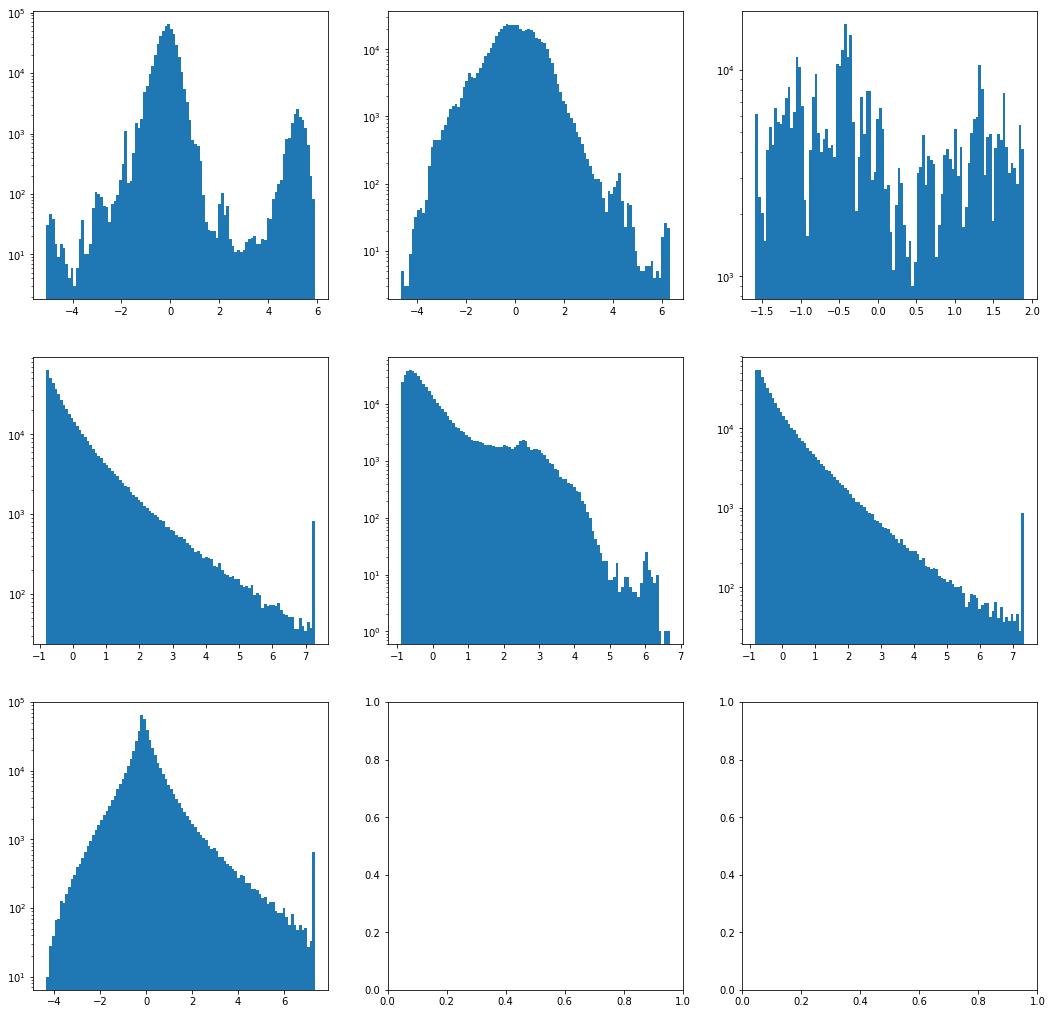

In [27]:
plt.subplots(3,3, figsize=(18, 18))
for i in np.arange(n_ch):
    plt.subplot(3, 3, i+1)
    plt.hist(in_image[:, :, :, i].ravel(), bins=100);
    plt.semilogy()

### Split data to train/val

In [29]:
# Shuffle data
if shuffle_train:
    in_image, labels_train = sk_shuffle(in_image, labels_train)

In [30]:
test_image.shape, in_image.shape

((3816, 8, 16, 7), (3177, 8, 16, 7))

## CNN Model

We have 3 main components
    - Helper functions to get precision/recall from keras
    - CNN model
    - Image generator: augments the data with a generator function

In [31]:
"""
Helper functions to get precision/recall from Keras. 
"""

### Use this class with model.fit_generator() to get precision/recall/f1 scores.
### First, we collect all validation batches, then calculate the scores. If we calculate the scores for each batch, we get incorrect scores.
### Validation data is not available readily in the model due to generator so we need to use this special class.
class GeneratorMetrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def get_data(self):
        return self._data

    def __init__(self, validation_generator, validation_steps):
        self.validation_generator = validation_generator
        self.validation_steps = int(validation_steps)
    
    def on_epoch_end(self, batch, logs={}):
        y_val_all = []
        y_predict_all = []

        for batch_index in range(self.validation_steps):
            X_val, y_val = next(self.validation_generator)            
            y_predict = np.asarray(self.model.predict(X_val))

            y_val = np.argmax(y_val, axis=1)
            y_predict = np.argmax(y_predict, axis=1)
            
            y_val_all = y_val_all + list(y_val)
            y_predict_all = y_predict_all + list(y_predict)
        
        self._data.append({
            'val_recall': recall_score(y_val_all, y_predict_all, average=None),
            'val_precision': precision_score(y_val_all, y_predict_all, average=None),
            'f1_score': f1_score(y_val_all, y_predict_all, average=None)
        })
        return

### Use this class with model.fit() to get precision/recall scores.
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        self._data.append({
            'val_recall': recall_score(y_val, y_predict, average=None),
            'val_precision': precision_score(y_val, y_predict, average=None),
            'f1_score': f1_score(y_val, y_predict, average=None)
        })
        return

    def get_data(self):
        return self._data

# Convert the precision/recall array from above to a dataframe with class numbers and epoch numbers
def pr_keras_to_df(pr, n_classes, init_epoch):
    pr_df = pd.DataFrame()
    i = init_epoch
    for prx in pr:
        prx.update({'epoch':i})
        prx.update({'class':np.arange(n_classes)})
        pr_df = pr_df.append(pd.DataFrame(prx))
        i+=1
    if le is not None:
        pr_df['class_desc'] = le.inverse_transform(pr_df['class'])
    return pr_df

metrics_prf = Metrics()
pr_df = pd.DataFrame()

In [32]:
"""
Actual CNN model:
5 CNN layers.
1 output dense layer with softmax activation.
"""

from keras import layers
from keras import models
from keras.utils.vis_utils import plot_model
from keras import optimizers
from sklearn.model_selection import train_test_split

# Model
# + Dropout
# + image 8*16
# + network changes
def create_model_extra(input_shape, num_classes):

    img_height =input_shape[1]
    img_width = input_shape[2]
    img_channels = input_shape[3]
    #num_classes = n_classes

    def HappyModel(x):
        """
        Simple CNN

        """
        def add_common_layers(y):
            y = layers.BatchNormalization()(y)
            y = layers.ReLU()(y)

            return y

        # conv1
        x = layers.Conv2D(64, kernel_size=(2, 4), strides=(1, 1), padding='same')(x)
        x = add_common_layers(x)
        #x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)

        # conv2
        x = layers.Conv2D(128, kernel_size=(2, 4), strides=(1, 1), padding='same')(x)
        x = add_common_layers(x)
        #x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 1), padding='same')(x)

        # conv3
        x = layers.Dropout(0.5)(x)
        x = layers.Conv2D(256, kernel_size=(3, 8), strides=(1, 1), padding='valid')(x)
        x = add_common_layers(x)
        #x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

        # conv4
        x = layers.Conv2D(512, kernel_size=(4, 8), strides=(2, 2), padding='same')(x)
        x = add_common_layers(x)

        # conv5
        x = layers.Conv2D(1024, kernel_size=(2, 4), strides=(2, 2), padding='same')(x)
        x = add_common_layers(x)

        # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
        x = layers.Flatten()(x)
        x = layers.Dense(num_classes, activation='softmax', name='softmax_out')(x)

        return x


    image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
    network_output = HappyModel(image_tensor)

    model = models.Model(inputs=[image_tensor], outputs=[network_output])
    print(model.summary())
    return model

print("Here's a sample of the model above:")
temp_model = create_model_extra([1,8,16,7],9)

Here's a sample of the model above:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 16, 7)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 16, 64)         3648      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 16, 64)         256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 16, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 16, 128)        65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 16, 128)        512       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 8, 1

In [33]:
# Image data generator. Applies a random horizontal and vertical shift. It rolls the image, so pixels leaving from end, roll back to the begining of image.
""" 
Why use this? This is similar to vertical/horizontal flipping of an image but it is more general because it 
rolls the data by applying random shift. The point where we start measurement does not matter. So we can
shift the data in any direction. This helps us in generalizing the model better.
I decided to do the normalization as a pre-process. See "Convert data to numpy images and apply normalization". 
"""
def image_generator_ysn(x, y=None, batch_size=64, shuffle=True, enable_shift=True):
    if shuffle:
        if y is not None:
            x, y = sk_shuffle(x, y)
        else:
            x = sk_shuffle(x)
    n_x = len(x)
    n_h = x.shape[1]
    n_w = x.shape[2]
    i = 0
    
    while True:
        
        batch_x = x[i: min(i+batch_size, n_x)]
        if y is not None:
            batch_y = y[i: min(i+batch_size, n_x)]

        if enable_shift:
            # horizontal shift
            shift = np.random.randint(-n_w, n_w, 1)
            batch_x = np.roll(batch_x, shift=shift, axis=2)

            # vertical shift
            shift = np.random.randint(-n_w, n_w, 1)
            batch_x = np.roll(batch_x, shift=shift, axis=1)

        i+=batch_size
        if i>=n_x:
            i=0
        if y is not None:
            yield( batch_x, batch_y )
        else:
            yield( batch_x)


In [34]:
# Confusion matrix plotter
# https://www.kaggle.com/artgor/where-do-the-robots-drive
import itertools

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

## Running the Model

Let's train the model and see how it performs

In [35]:
# Set up train/validation data

# 20% for validation: 18% realistically.
### Split train/validation and ensure all classes appear in both.
ok_split=False
i = 0
while (ok_split==False) and (i<10):
    X_train, X_val, Y_train, Y_val = train_test_split(in_image, labels_train, test_size=0.2)
    ok_split = ( len(np.unique(Y_train)) == len(np.unique(Y_val)) )
    i+=1
if not(ok_split):
    raise ValueE
    
#X_train = in_image
#Y_train = labels_train
#X_val   = val2_image
#Y_val   = val2_labels

In [36]:
# Build the model and run it
def run_model(max_epochs = 32):
    batch_size = 100

    # Create model and optimizer
    model2 = create_model_extra(X_train.shape, n_classes)
    plot_model(model2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)
    learning_rate = 0.001
    decay_rate = learning_rate / 200 #epochs
    optimizer_ = optimizers.Adamax(lr=learning_rate, epsilon=1e-8, decay=decay_rate) # decay=1e-4
    model2.compile(optimizer=optimizer_, loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up the metrics generator. I wrote a helper function "GeneratorMetrics()" to do this.
    validation_steps=np.ceil(X_val.shape[0]/batch_size)
    gen_metric = GeneratorMetrics(
        image_generator_ysn(X_val, Y_val, batch_size=batch_size, shuffle=False),
        validation_steps)

    # Train the model
    model2.fit_generator(image_generator_ysn(X_train, Y_train, batch_size=batch_size),
                        steps_per_epoch=np.ceil(X_train.shape[0]/batch_size),
                        epochs=max_epochs,
                        validation_data=image_generator_ysn(X_val, Y_val, batch_size=batch_size, shuffle=False),
                        validation_steps=validation_steps,
                        callbacks=[gen_metric]
                        )
    # Predict output
    #out = model2.predict_generator(
    #            image_generator_ysn(val2_image, batch_size=batch_size, shuffle=False, enable_shift=False),
    #            np.ceil(val2_image.shape[0]/batch_size)).argmax(axis=1)

    # Save the model
    from time import gmtime, strftime
    mname = 'YSNModel_8x16_dropCH_' + '_'+ strftime("%Y-%m-%d %H:%M:%S", gmtime()) + '.h5'
    model2.save(mname)
    
    return model2

In [37]:
model2 = run_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8, 16, 7)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 16, 64)         3648      
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 16, 64)         256       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 8, 16, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 16, 128)        65664     
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 16, 128)        512       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 8, 16, 128)        0         
__________

In [38]:
# Plotting of loss/accuracy
def plot_loss_acc(model2):
    f = plt.figure()
    #fig, ax = plt.subplots(1,2,figsize=(15, 4)
    ### Plot loss/acc
    plt.subplots(1,2, figsize=(15, 4))
    plt.subplot(1,2, 1)
    plt.plot(model2.history.history['loss'])
    plt.plot(model2.history.history['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.title('Loss')

    plt.subplot(1,2, 2)
    plt.plot(model2.history.history['acc'])
    plt.plot(model2.history.history['val_acc'])
    plt.legend(['acc', 'val_acc'])
    plt.title('Accuracy')
    plt.show()

<Figure size 432x288 with 0 Axes>

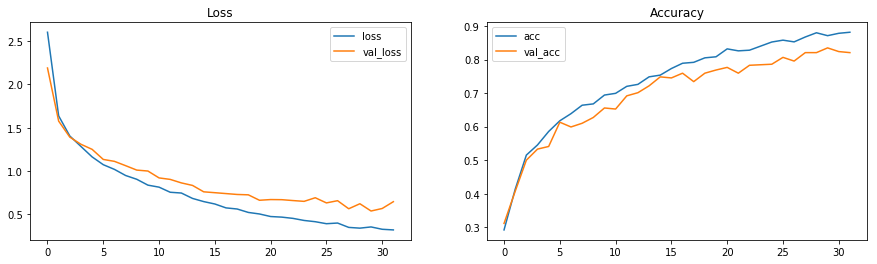

In [39]:
plot_loss_acc(model2)

We see that validation loss closely follows the training loss. The training results seem to be very good. This might be an issue with generalizing the model. 

Confusion matrix below shows that most of the classes are predicted correctly in the validation set. Hard tiles is difficult to produce because it has small sample size in training.

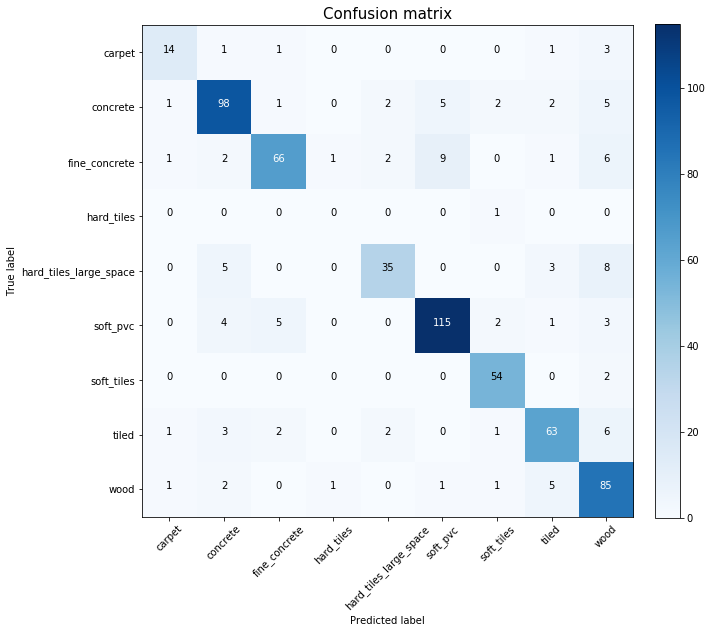

In [40]:
batch_size = 100
y_val_pred = model2.predict_generator(
    image_generator_ysn(X_val, batch_size=batch_size, shuffle=False, enable_shift=False),
    np.ceil(X_val.shape[0]/batch_size)).argmax(axis=1)

plot_confusion_matrix(Y_val.argmax(axis=1), y_val_pred, le.classes_)

In [41]:
# This is the submission file for test data.
out = model2.predict_generator(
    image_generator_ysn(test_image, batch_size=batch_size, shuffle=False, enable_shift=False),
    np.ceil(test_image.shape[0]/batch_size)).argmax(axis=1)
#out = predict_gen(test_image, model2).argmax(axis=1)
submission['surface'] = le.inverse_transform(out)
submission.to_csv('sample_submission.csv', index=False)
submission.head(10)

,series_id,surface
0,0,tiled
1,1,carpet
2,2,tiled
3,3,wood
4,4,soft_tiles
5,5,carpet
6,6,soft_pvc
7,7,concrete
8,8,wood
9,9,wood


## Remove Orientation data

Let's see how good we can do without orientation data. Basically we are just using angular velocity and linear acceleration.

In [42]:
X_train = in_image[:,:,:, 3:]
Y_train = labels_train
X_val   = val2_image[:,:,:, 3:]
Y_val   = val2_labels

In [43]:
model2 = run_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8, 16, 4)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 16, 64)         2112      
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 16, 64)         256       
_________________________________________________________________
re_lu_11 (ReLU)              (None, 8, 16, 64)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 16, 128)        65664     
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 16, 128)        512       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 8, 16, 128)        0         
__________

<Figure size 432x288 with 0 Axes>

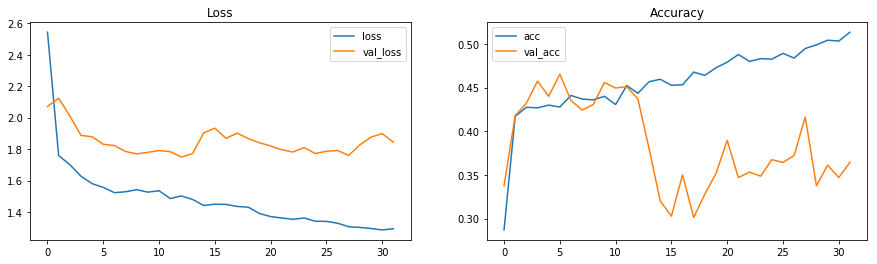

In [44]:
plot_loss_acc(model2)

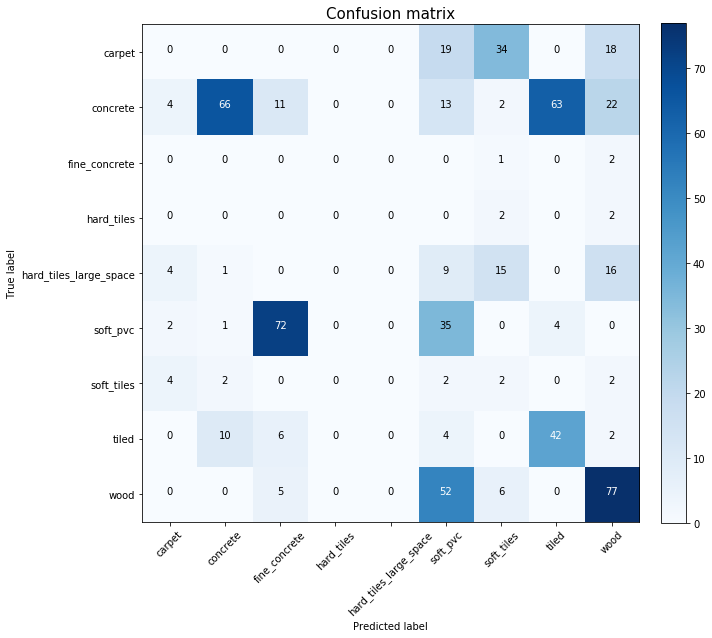

In [45]:
y_val_pred = model2.predict_generator(
    image_generator_ysn(X_val, batch_size=batch_size, shuffle=False, enable_shift=False),
    np.ceil(X_val.shape[0]/batch_size)).argmax(axis=1)

plot_confusion_matrix(Y_val.argmax(axis=1), y_val_pred, le.classes_)

We removed orientation features and both the train and validation accuracy dropped significantly. In my opinion this should be the baseline for optimizing the algorithm. Since on Kaggel, many people are using orientation, it is difficult to get to the leaderboard without using orientation.
Due to this issue, I will wrap up this work at this point. This was a great learning experience for me. I have implemented an algorithm in Random Forest to tackle this issue as well. Check it out in my github account.